In [1]:
import IJulia

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 7
fig_height = 5
fig_format = :retina
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie

  # CairoMakie's display() in PDF format opens an interactive window
  # instead of saving to the ipynb file, so we don't do that.
  # https://github.com/quarto-dev/quarto-cli/issues/7548
  if fig_format == :pdf
    CairoMakie.activate!(type = "png")
  else
    CairoMakie.activate!(type = string(fig_format))
  end
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = raw"/Users/hirofumi48/162348.github.io/posts/2025/PDMP"
  if !isempty(run_path)
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


In [2]:
#| output: false
using PlotlyJS

# 格子生成
us = collect(-1.0:0.05:1.0)
vs = collect(-1.0:0.05:1.0)

# 平面を Mesh3d でプロットする関数
function plane_mesh(xs, ys, zs; col)
    mesh3d(x=xs, y=ys, z=zs, opacity=0.5, color=col, showscale=false)
end

# 各平面の座標配列を作成
x1 = hcat([[u,u,v] for u in us, v in vs]...)
x2 = hcat([[v,u,u] for u in us, v in vs]...)
x3 = hcat([[u,v,u] for u in us, v in vs]...)

WebIO._IJuliaInit()

3×1681 Matrix{Float64}:
 -1.0  -0.95  -0.9  -0.85  -0.8  -0.75  …  0.75  0.8  0.85  0.9  0.95  1.0
 -1.0  -1.0   -1.0  -1.0   -1.0  -1.0      1.0   1.0  1.0   1.0  1.0   1.0
 -1.0  -0.95  -0.9  -0.85  -0.8  -0.75     0.75  0.8  0.85  0.9  0.95  1.0

In [3]:
using PlotlyJS

# パラメータ格子
us = collect(-1.0:0.05:1.0)
vs = collect(-1.0:0.05:1.0)
m, n = length(us), length(vs)

# 頂点リスト（flatten した順序で）
x = Float64[]
y = Float64[]
z = Float64[]
for u in us, v in vs
    push!(x, u); push!(y, u); push!(z, v)   # plane x=y
end

# 三角形フェイスを作成
i = Int[]
j = Int[]
k = Int[]
for ii in 1:m-1
    for jj in 1:n-1
        p1 = (ii-1)*n + jj
        p2 = ii*n       + jj
        p3 = (ii-1)*n + jj+1
        p4 = ii*n       + jj+1
        # 2 つの三角形に分割
        push!(i, p1-1); push!(j, p2-1); push!(k, p3-1)
        push!(i, p2-1); push!(j, p4-1); push!(k, p3-1)
    end
end

trace = mesh3d(
    x=x, y=y, z=z,
    i=i, j=j, k=k,                # ★自前の分割インデックス
    opacity=0.5, color="red",
    showscale=false
)

mesh3d with fields color, i, j, k, opacity, showscale, type, x, y, and z


In [4]:
using PlotlyJS, PlotlyBase

using Plots
plotlyjs()

# (1) プロットを作成
plt = Plot(
    [
      trace,
      plane_mesh(x2[1,:], x2[2,:], x2[3,:], col="green"),
      plane_mesh(x3[1,:], x3[2,:], x3[3,:], col="blue"),
    ],
    Layout(
      scene = attr(
        xaxis_title="x", yaxis_title="y", zaxis_title="z"
      )
    )
)

io = IOBuffer()
PlotlyBase.to_html(io, plt, full_html=false)
HTML(read(io, String))  # Quartoはこの生HTMLをそのまま出力に埋め込みます

HTML{String}("")

In [5]:
plt

data: [
  "mesh3d with fields color, i, j, k, opacity, showscale, type, x, y, and z",
  "mesh3d with fields color, opacity, showscale, type, x, y, and z",
  "mesh3d with fields color, opacity, showscale, type, x, y, and z"
]

layout: "layout with fields margin, scene, and template"

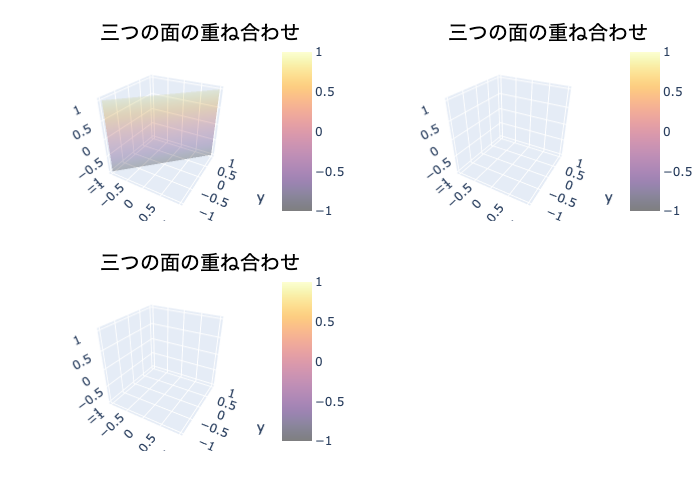

In [6]:
using Plots

# ① PlotlyJS バックエンドに切り替え
plotlyjs()

# ② パラメータ格子
us = range(-1.0, 1.0, length=41)
vs = range(-1.0, 1.0, length=41)

# ③ 各平面を Z = f(X,Y) の形で定義
#    （plane1: x = y  → X=us,Y=us, Z=v を関数化する）
X = [u for u in us, v in vs]
Y = [u for u in us, v in vs]
Z1 = [v for u in us, v in vs]         # plane x=y
Z2 = [u for u in us, v in vs]         # plane y=z を v→u, u→v と読み替え
Z3 = [u for u in us, v in vs]         # plane z=x を同様に設定

# ④ surface プロット
p1 = Plots.surface(X, Y, Z1, opacity=0.5, showlegend=false)
p2 = Plots.surface(X, Y, Z2, opacity=0.5, showlegend=false)
p3 = Plots.surface(X, Y, Z3, opacity=0.5, showlegend=false)

# ⑤ 軸ラベルなどのレイアウト設定
plt = Plots.plot(
  p1, p2, p3,
  xlabel="x", ylabel="y", zlabel="z",
  title="三つの面の重ね合わせ"
)

# 最後にオブジェクトを返すだけで、Quarto が自動的に埋め込みます
plt